In [1]:
import requests
import urllib.request
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from pickle import load
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=100'
response = requests.get(url)

In [3]:
soup = BeautifulSoup(response.text, "html.parser")

In [4]:
data = json.loads(str(soup))

df = pd.DataFrame(data['Data']['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
df = df.drop(['conversionType', 'conversionSymbol'], axis=1 )
target_col = 'close'

df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-04,19541.62,18603.79,19448.44,42234.35,8.043665e+08,18665.00
2020-12-05,19178.40,18514.92,18665.00,20517.48,3.884669e+08,19156.84
2020-12-06,19417.33,18885.88,19156.84,21172.50,4.057086e+08,19378.94
2020-12-07,19411.51,18909.97,19378.94,24908.46,4.773346e+08,19181.41
2020-12-08,19295.38,18227.31,19181.41,46151.65,8.665434e+08,18323.52


In [5]:
model = load_model('best_model.h5')
scaler = load(open('scaler.pkl', 'rb'))

In [6]:
window_len = model.input_shape[1]

In [7]:
scaled = scaler.transform(df)
scaled_df = pd.DataFrame(scaled, columns=df.columns,index=df.index)

In [8]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):

    x = extract_window_data(df, window_len)
    y = df[target_col][window_len:].values
    
    return x, y


In [9]:
x_test, y_test = prepare_data(scaled_df, target_col, window_len)

In [10]:
preds = model.predict(x_test).squeeze()

preds_arr = np.zeros([preds.shape[0], 6])
preds_arr[:, 5] = preds

preds = scaler.inverse_transform(preds_arr)

preds_df = pd.DataFrame(preds, columns=df.columns)

preds_df.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,17456.556647
1,0.04951,0.01,0.04951,0.0,0.0,17550.990285
2,0.04951,0.01,0.04951,0.0,0.0,17651.673606
3,0.04951,0.01,0.04951,0.0,0.0,18611.621509
4,0.04951,0.01,0.04951,0.0,0.0,20040.611607


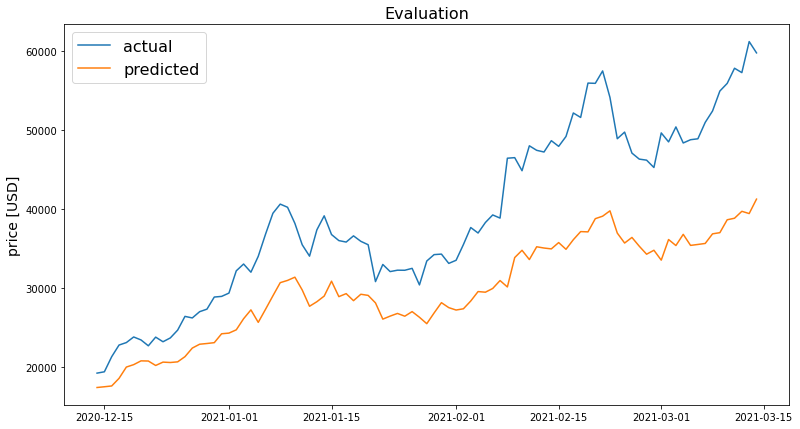

In [11]:
predicted_closing_prices = preds_df[target_col].values
actual_closing_prices = df[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [12]:
w = scaled_df[len(df)-window_len:len(df)]
wn = np.array(w)
wn = wn[np.newaxis, :, :]

t = model.predict(wn).squeeze()
t_arr = np.zeros(6)
t_arr[5] = t
t_arr = t_arr[np.newaxis, :]
tomorrow = scaler.inverse_transform(t_arr)
tomorrow = tomorrow[0,5]

In [13]:
save_data = {'time': df.index[window_len:], 'actual': df[target_col][window_len:], 'preds': predicted_closing_prices}
save_df = pd.DataFrame(data=save_data)
save_df = save_df.set_index('time')

In [14]:
save_df

,actual,preds
time,,
2020-12-14,19274.69,17456.556647
2020-12-15,19441.96,17550.990285
2020-12-16,21352.13,17651.673606
2020-12-17,22822.17,18611.621509
2020-12-18,23135.57,20040.611607
...,...,...
2021-03-10,55893.31,38656.518027
2021-03-11,57809.41,38851.817172
2021-03-12,57256.22,39727.538485


In [58]:
dt = save_df.index[-1] - save_df.index[-2]
tomorrow_df = pd.DataFrame([[save_df.index[-1] + dt, tomorrow]], columns=['time', 'preds'])
tomorrow_df = tomorrow_df.set_index('time')

In [59]:
tomorrow_df

,preds
time,
2021-03-15,40792.710531


In [60]:
save_df = save_df.append(tomorrow_df)

In [61]:
save_df

,actual,preds
time,,
2020-12-14,19274.69,17456.556647
2020-12-15,19441.96,17550.990285
2020-12-16,21352.13,17651.673606
2020-12-17,22822.17,18611.621509
2020-12-18,23135.57,20040.611607
...,...,...
2021-03-11,57809.41,38851.817172
2021-03-12,57256.22,39727.538485
2021-03-13,61179.79,39442.207001


In [62]:
save_df.to_json(r'results.json')